In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 543ms/step - loss: 195.6164 - mae: 196.0720
Epoch 2/100
8/8 [==============================] - 1s 96ms/step - loss: 194.5325 - mae: 195.2834
Epoch 3/100
8/8 [==============================] - 1s 94ms/step - loss: 192.9727 - mae: 194.0105
Epoch 4/100
8/8 [==============================] - 1s 101ms/step - loss: 192.1908 - mae: 192.4086
Epoch 5/100
8/8 [==============================] - 1s 121ms/step - loss: 190.2551 - mae: 190.5219
Epoch 6/100
8/8 [==============================] - 1s 114ms/step - loss: 187.3451 - mae: 188.3526
Epoch 7/100
8/8 [==============================] - 1s 134ms/step - loss: 185.5730 - mae: 185.8774
Epoch 8/100
8/8 [==============================] - 1s 109ms/step - loss: 182.9677 - mae: 183.0458
Epoch 9/100
8/8 [==============================] - 1s 99ms/step - loss: 179.8839 - mae: 179.8091
Epoch 10/100
8/8 [==============================] - 1s 85ms/step - loss: 175.3425 - mae: 176.0967
Epoch 11/100
8/8 [=====

8/8 [==============================] - 1s 96ms/step - loss: 18.8307 - mae: 18.8961
Epoch 87/100
8/8 [==============================] - 1s 94ms/step - loss: 16.5966 - mae: 17.1911
Epoch 88/100
8/8 [==============================] - 1s 93ms/step - loss: 16.1220 - mae: 16.4739
Epoch 89/100
8/8 [==============================] - 1s 94ms/step - loss: 29.6275 - mae: 29.9583
Epoch 90/100
8/8 [==============================] - 1s 102ms/step - loss: 26.5237 - mae: 27.0936
Epoch 91/100
8/8 [==============================] - 1s 100ms/step - loss: 38.2799 - mae: 38.7275
Epoch 92/100
8/8 [==============================] - 1s 98ms/step - loss: 37.9721 - mae: 38.5379
Epoch 93/100
8/8 [==============================] - 1s 94ms/step - loss: 41.1031 - mae: 41.3684
Epoch 94/100
8/8 [==============================] - 1s 100ms/step - loss: 59.8358 - mae: 59.7096
Epoch 95/100
8/8 [==============================] - 1s 102ms/step - loss: 58.7720 - mae: 56.8583
Epoch 96/100
8/8 [==============================]

[1e-08, 0.0001, 0, 30]

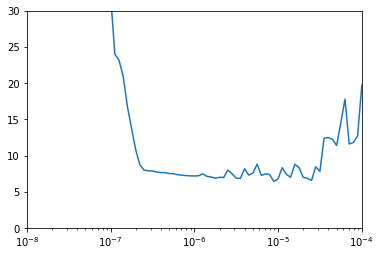

In [5]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 3s 416ms/step - loss: 80.8704 - mae: 83.5783
Epoch 2/400
8/8 [==============================] - 1s 93ms/step - loss: 24.4966 - mae: 24.3853
Epoch 3/400
8/8 [==============================] - 1s 96ms/step - loss: 18.2014 - mae: 18.7075
Epoch 4/400
8/8 [==============================] - 1s 100ms/step - loss: 14.2670 - mae: 14.6786
Epoch 5/400
8/8 [==============================] - 1s 112ms/step - loss: 10.8972 - mae: 11.2671
Epoch 6/400
8/8 [==============================] - 1s 105ms/step - loss: 11.2944 - mae: 12.4496
Epoch 7/400
8/8 [==============================] - 1s 104ms/step - loss: 13.0979 - mae: 13.4533
Epoch 8/400
8/8 [==============================] - 1s 114ms/step - loss: 12.4517 - mae: 12.6597
Epoch 9/400
8/8 [==============================] - 1s 96ms/step - loss: 10.0349 - mae: 11.0609
Epoch 10/400
8/8 [==============================] - 1s 94ms/step - loss: 11.5311 - mae: 11.6362
Epoch 11/400
8/8 [=========================

8/8 [==============================] - 1s 103ms/step - loss: 6.2888 - mae: 6.7442
Epoch 88/400
8/8 [==============================] - 1s 111ms/step - loss: 5.9144 - mae: 6.4914
Epoch 89/400
8/8 [==============================] - 1s 108ms/step - loss: 6.4001 - mae: 6.9281
Epoch 90/400
8/8 [==============================] - 1s 102ms/step - loss: 4.7996 - mae: 5.2939
Epoch 91/400
8/8 [==============================] - 1s 120ms/step - loss: 4.6667 - mae: 5.1508 0s - loss: 4.6655 - mae: 5.140
Epoch 92/400
8/8 [==============================] - 1s 126ms/step - loss: 5.3796 - mae: 5.8568
Epoch 93/400
8/8 [==============================] - 1s 168ms/step - loss: 5.3632 - mae: 5.7547
Epoch 94/400
8/8 [==============================] - 1s 97ms/step - loss: 4.8187 - mae: 5.4104
Epoch 95/400
8/8 [==============================] - 1s 101ms/step - loss: 5.5445 - mae: 6.0358
Epoch 96/400
8/8 [==============================] - 1s 109ms/step - loss: 5.5615 - mae: 6.1642
Epoch 97/400
8/8 [===============

8/8 [==============================] - 1s 119ms/step - loss: 4.4669 - mae: 4.9192
Epoch 173/400
8/8 [==============================] - 1s 99ms/step - loss: 5.2785 - mae: 5.7858
Epoch 174/400
8/8 [==============================] - 1s 113ms/step - loss: 5.1023 - mae: 5.5646
Epoch 175/400
8/8 [==============================] - 1s 105ms/step - loss: 5.0074 - mae: 5.4001
Epoch 176/400
8/8 [==============================] - 1s 144ms/step - loss: 4.5876 - mae: 5.0255
Epoch 177/400
8/8 [==============================] - 1s 130ms/step - loss: 4.3387 - mae: 4.8371
Epoch 178/400
8/8 [==============================] - 1s 150ms/step - loss: 4.2740 - mae: 4.7633
Epoch 179/400
8/8 [==============================] - 1s 163ms/step - loss: 5.0448 - mae: 5.6986
Epoch 180/400
8/8 [==============================] - 1s 117ms/step - loss: 4.6699 - mae: 5.1774
Epoch 181/400
8/8 [==============================] - 1s 136ms/step - loss: 4.2829 - mae: 4.7159
Epoch 182/400
8/8 [==============================] - 1s

8/8 [==============================] - 1s 94ms/step - loss: 4.1557 - mae: 4.6394
Epoch 258/400
8/8 [==============================] - 1s 93ms/step - loss: 3.9992 - mae: 4.4997
Epoch 259/400
8/8 [==============================] - 1s 94ms/step - loss: 4.1748 - mae: 4.6501
Epoch 260/400
8/8 [==============================] - 1s 96ms/step - loss: 4.3064 - mae: 4.7874
Epoch 261/400
8/8 [==============================] - 1s 94ms/step - loss: 4.5273 - mae: 4.9968
Epoch 262/400
8/8 [==============================] - 1s 96ms/step - loss: 5.8893 - mae: 6.3395
Epoch 263/400
8/8 [==============================] - 1s 92ms/step - loss: 5.2955 - mae: 5.7360
Epoch 264/400
8/8 [==============================] - 1s 93ms/step - loss: 5.6031 - mae: 6.1010
Epoch 265/400
8/8 [==============================] - 1s 91ms/step - loss: 5.1282 - mae: 5.6550
Epoch 266/400
8/8 [==============================] - 1s 92ms/step - loss: 4.5185 - mae: 5.0165
Epoch 267/400
8/8 [==============================] - 1s 93ms/ste

Epoch 343/400
8/8 [==============================] - 1s 113ms/step - loss: 5.2255 - mae: 5.5578
Epoch 344/400
8/8 [==============================] - 1s 100ms/step - loss: 4.0885 - mae: 4.5448
Epoch 345/400
8/8 [==============================] - 1s 100ms/step - loss: 4.4410 - mae: 4.9823
Epoch 346/400
8/8 [==============================] - 1s 94ms/step - loss: 5.0706 - mae: 5.5772
Epoch 347/400
8/8 [==============================] - 1s 98ms/step - loss: 4.3188 - mae: 4.8577
Epoch 348/400
8/8 [==============================] - ETA: 0s - loss: 5.4345 - mae: 5.918 - 1s 96ms/step - loss: 5.4465 - mae: 6.0146
Epoch 349/400
8/8 [==============================] - 1s 96ms/step - loss: 5.3283 - mae: 5.9673
Epoch 350/400
8/8 [==============================] - 1s 98ms/step - loss: 5.3591 - mae: 5.8118
Epoch 351/400
8/8 [==============================] - 1s 96ms/step - loss: 4.7025 - mae: 5.1913
Epoch 352/400
8/8 [==============================] - 1s 96ms/step - loss: 5.0106 - mae: 5.4544
Epoch 353

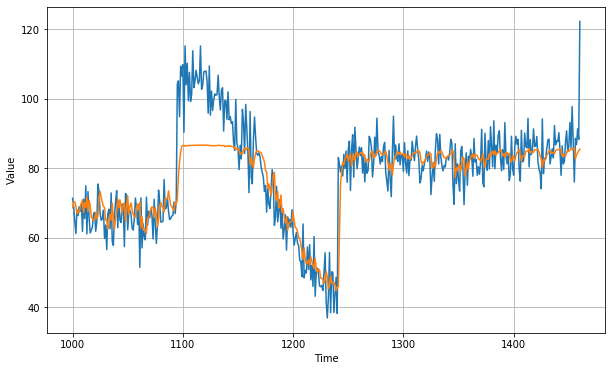

In [7]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.983605

<Figure size 432x288 with 0 Axes>

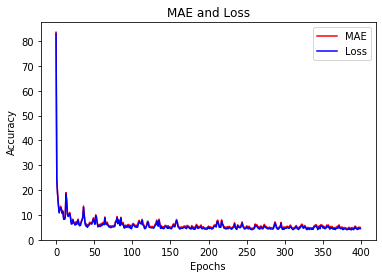

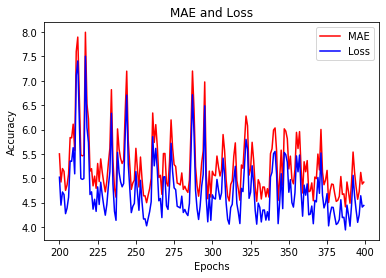

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()